#### Histograms quantifying the number of equilibrium points of the full multiscale model
Import the required libraries

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import style

# using the style for the plot
plt.style.use('seaborn-v0_8-bright')

#### Code chunk 1: Within-Host model

The within-host model parameters are given in a vector with form

$params = (\Lambda_T, \beta_{WH}, d, k, \delta, p, c)$

In [64]:
# Dengue virus
WHparamsDENV = np.array([590, 1.0e-4, 0.03, 4, 2.5, 50, 13])

# Zika virus
WHparamsZIKV = np.array([159, 2e-5, 0.03, 4, 3.5, 1000, 10])

# West-nile virus
WHparamsWNV = np.array([4020, 4e-4, 0.03, 3, 23.03, 57.88 , 44.43])




Fuction for the within-host reproduction number $R_w$

In [67]:
def Rw(x):
    """ This function receives the within-host parameters and returns Rw"""
    L_T, betaWH, d, k, delta, p ,c = x[0], x[1], x[2], x[3], x[4], x[5], x[6]

    Rw = (p*k*betaWH*L_T)/(c*(k+d)*delta*d)
    return Rw



Define the within-host equilibrium viral load $V^{*}$ as a function of $i_M$ and the within-host parameters

In [70]:
def g_H(iM):
    a = 1e7 
    x = a*iM
    return x
    
def Vstar(iM, x):
    """ This function receives an scalar iM and the vector of within-host parameters x"""
    L_T, betaWH, d, k, delta, p ,c = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    term1 = d*(Rw(x)-1)/betaWH
    term2 = g_H(iM)/c
    raiz1 = (term1 + term2)**2
    raiz2 = (4*d*g_H(iM))/(c*betaWH)
    V = 0.5*(term1 + term2 + np.sqrt(raiz1 + raiz2))
    return V
    
             
    

#### Code chunk 2: The Within-Vector model

The within-vector parameters are given next

In [73]:
rm, Km, m, A, rs, Ks = 1.26, 433000, 0.11, 19500, 1.77, 6840000

paramsWV = np.array([rm, Km, m, A, rs, Ks])

Define the equilibrium viral load in the midgut $W_m^{*}$ as function of $i_H$ and the within-vector parameters

In [76]:
# function g_M(i_H)

def g_M(iH):
    a = 1e7
    x = a*iH
    return x

Define $W_m^{*}$ as function of $i_H$ and the within-vector parameters

In [79]:
def Wm(iH, x):
    """ This function receives an scalar 0<iH<1 and the vector of within-vector parameters x"""
    rm, Km, m, A, rs, Ks = x[0], x[1], x[2], x[3], x[4], x[5]
    term1 = (1-m/rm)*Km
    raiz1 = term1**2
    q = 1e-5
    raiz2 = 4*q*g_M(iH)*Km/rm
    Wm = 0.5*(term1 + np.sqrt(raiz1 + raiz2))
    return Wm

Now that we have defined $W_m^{*}$, we can express the equilibrium viral load of the salivary glands $W_s^{*}$ as function of $i_H$

In [82]:
def Ws(iH, x):
    """ This function receives an scalar 0<iH<1 and the vector of within-vector parameters x"""
    rm, Km, m, A, rs, Ks = x[0], x[1], x[2], x[3], x[4], x[5]
    q = 1e-5
    newKs = Ks + (1-q)*g_M(iH)
    raiz1 = rs**2
    raiz2 = 4*rs/newKs
    raiz3 = m*Wm(iH, x)**2/(A + Wm(iH, x)**2)
    full_raiz = raiz1 + raiz2*raiz3
    Ws = 0.5*(newKs + (newKs/rs)*np.sqrt(full_raiz))
    return Ws


#### Code chunk 3: The between-host model

The parameter for the population-level epidemic model will be given in a vector of the form

$ x = (\Lambda_H, \Lambda_M, \mu_H, \mu_M, \beta_h, \beta_m, \sigma_H, \sigma_M, \gamma_H)$

Note that as discussed in the SM, the host population can be normalized i.e. $N^{*}= \Lambda_H/\mu_H = 1$.

In [85]:
# Mean parameters for DENV
xDENV = np.array([1, 1.01, 1, 0.07, 0.67, 0.39, 1/6, 1/8, 1/4.5]) 

# Mean parameters for ZIKV
xZIKV = np.array([1, 1.15, 1, 0.066, 0.96, 0.26, 1/8.5, 1/7, 1/5.5]) 

# Mean parameters for WNV
xWNV = np.array([1, 0.42, 1, 0.12, 0.44, 0.974, 1/0.5, 1/3.5, 1/2.3]) 



Next we define the nonlinear functional forms for the transmission rates
\begin{eqnarray}
\beta_H(W_s^{*}(i_H)),\quad
\beta_M(V^{*}(i_M))
\end{eqnarray}
The functions are defined in the manuscript.

Note that the functions depend on the (fraction) infected host and mosquito classes, respectively, but also $\beta_H$ depends on the within-vector parameters
while $\beta_M$ depends on the within-host parameters.

In [139]:
#------------------------------------------------------------------- betaH

# -------------------    Ferguson
def betaH_Ferguson(iH, WV_params, theta0, theta1):
    """ betaH as function of 0<iH<1 and the WV parameters"""
    logWs = np.log10(0.69*Ws(iH, WV_params)+1)
    exponent = -(logWs/ theta0)**theta1
    b = 1 - np.exp(exponent)
    return b



def betaH_Ferguson_DENV(iH, WV_params):
    return betaH_Ferguson(iH, WV_params, theta0=6.12, theta1=6.77)

def betaH_Ferguson_ZIKV(iH, WV_params):
    return betaH_Ferguson(iH, WV_params, theta0=4.19, theta1=4.37)

def betaH_Ferguson_WNV(iH, WV_params):
    return betaH_Ferguson(iH, WV_params, theta0 = 7.91, theta1=2.93)



# --------------------- Hill
def betaH_Hill(iH, WV_params, gamma0, gamma1):
    logWs = np.log10(0.69*Ws(iH, WV_params) + 1)
    
    b = (logWs**gamma1)/(gamma0 + logWs**gamma1)
    return b



def betaH_Hill_DENV(iH, WV_params):
    return betaH_Hill(iH, WV_params, gamma0=np.exp(16), gamma1=9.20)

def betaH_Hill_ZIKV(iH, WV_params):
    return betaH_Hill(iH, WV_params, gamma0=np.exp(6.69), gamma1=5.13)

def betaH_Hill_WNV(iH, WV_params):
    return betaH_Hill(iH, WV_params, gamma0=np.exp(7.96), gamma1=4.11)





#--------------------------------------------------------------------- betaM

# ------------------- Ferguson
def betaM_Ferguson(iM, WH_params, theta0, theta1):
    """ betaM as function of 0<iM<1 and the within-host parameters"""
    logV = np.log10(Vstar(iM, WH_params)+1)
    exponent = -(logV/ theta0)**theta1
    b = 1 - np.exp(exponent)
    return b



def betaM_Ferguson_DENV(iM, WH_params):
    return betaM_Ferguson(iM, WH_params, theta0=6.12, theta1=6.77)

def betaM_Ferguson_ZIKV(iM, WH_params):
    return betaM_Ferguson(iM, WH_params, theta0=4.19, theta1=4.37)

def betaM_Ferguson_WNV(iM, WH_params):
    return betaM_Ferguson(iM, WH_params, theta0 = 7.91, theta1=2.93)



# --------------------- Hill
def betaM_Hill(iM, WH_params, gamma0, gamma1):
    """ betaM as function of 0<iM<1 and the within-host parameters"""
    logV = np.log10(Vstar(iM, WH_params)+1)
    
    b = (logV**gamma1)/(gamma0 + logV**gamma1) 
    return b



def betaM_Hill_DENV(iM, WH_params):
    return betaM_Hill(iM, WH_params, gamma0=np.exp(16), gamma1=9.20)

def betaM_Hill_ZIKV(iM, WH_params):
    return betaM_Hill(iM, WH_params, gamma0=np.exp(6.69), gamma1=5.13)

def betaM_Hill_WNV(iM, WH_params):
    return betaM_Hill(iM, WH_params, gamma0=np.exp(7.96), gamma1=4.11)







Now we will define the following function
\begin{equation}
\varphi (I_H) := \dfrac{\alpha_1 I_H N_H^{*}}{ (N_H^{*}-\alpha_3 I_H)\beta_H(W_s^{*}(i_H)) }.
\end{equation}

Note that in the numerical definition $\varphi$ will depend also on the between-host parameters, the within-vector parameter, and the functional form of $\beta_H$ (called linking_betaH)

Another important note: Mathematically the equilibrium value for $i_H$ is bounded and its maximum is below in such a way that $\alpha_3 i_H<1$ (see the main text), therefore fesible values for $i_H$ can be way below 1. Furthermore, when $1=\alpha_3 i_H$ the equilibrium is undefined and can lead to numerical issues.

In [142]:
def varphi(I_H, BH_params, WV_params, linking_betaH):
    """ varphi as a function of I_H and the between-host parameters and the within-vector parameters"""
    x = BH_params
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliary alphas
    alpha1 = (sigmaH + muH)*(gammaH + muH)/sigmaH
    alpha3 = (gammaH + muH)/sigmaH + 1 + gammaH/muH
    
    num = alpha1*I_H*Nh
    iH = I_H/Nh

    # linkking beta
    betaH = linking_betaH
    den = betaH(iH, WV_params)*(Nh - alpha3*I_H)
    return num/den



Likewise, we will define the function
\begin{equation}
\psi(I_M) := \dfrac{\alpha_2 I_M N_H^{*}}{\beta_M(V^{*}(i_M))(N_M^{*} -\alpha_4 I_M)}
\end{equation}

Note that in the numerical definition $\psi$ will depend also on the between-host parameters, the within-host parameter, and the functional form of $\beta_M$ (called linking_betaM)

Another important note: Mathematically the equilibrium value for $i_M$ is bounded and its maximum is below in such a way that $\alpha_4 i_H<1$ (see the main text), therefore feasible values for $i_M$ can be way below 1.

In [145]:
def psi(I_M,  BH_params, WH_params, linking_betaM):
    """ psi as a function of I_M , the between-host parameters, and the within-host parameters"""
    x = BH_params
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliary alphas
    alpha2 = (sigmaM + muM)*muM/sigmaM
    alpha4 = muM/sigmaM + 1
    
    num = alpha2*I_M*Nh
    iM = I_M/Nm

    # linking beta
    betaM = linking_betaM
    den = betaM(iM, WH_params)*(Nm - alpha4*I_M)
    return num/den


Next we define an auxiliar function for plotting $\varphi$ and $\psi$ on the same figure

In [148]:
def plotVarphiPsi(BH_params, WH_params, WV_params, linking_betaH, linking_betaM):
    x = BH_params
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliar alphas
    alpha3 = (gammaH + muH)/sigmaH + 1 + gammaH/muH
    alpha4 = muM/sigmaM + 1

    # maximum equilibrium value
    max_equiIH = 0.99/alpha3
    max_equiIM = 0.99/alpha4 

    # range for the infected host
    range_host = np.linspace(0, max_equiIH*Nh, 1000) 
    range_vector = np.linspace(0, max_equiIM*Nm, 1000) 

    # returns
    r_host = range_host/Nh
    r_vector = range_vector/Nm
    varphi_r = varphi(range_host, BH_params, WV_params, linking_betaH)/Nm
    psi_r = psi(range_vector, BH_params, WH_params, linking_betaM)/Nh

    return r_host, r_vector, varphi_r, psi_r








Next we import the function multi_root which computes the roots of a scalar function within a given interval based on scipy's 'root_scalar'. This function will be used to compute the intersections of $\varphi$ and $\psi$ 

In [151]:
from multi_root import multi_root

To investigate how the number of intersections between $\varphi$ and $\psi$ depend on the model parameters, we will use th Salib library.

Let us first import the required libraries

In [154]:
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from SALib.sample.morris import sample
from SALib.analyze.morris import analyze

Next, we redefine the above function to compute the intersections. The difference is that now this function is constrained to variations in the most influential parameters found by the GSA, namely  $\Lambda_T$, $\delta$, $p$, $c$, $K_s$, $\mu_M$, and $\sigma_H$.

In [157]:
def intersecciones2(X, BH_params, WH_params, WV_params, linking_betaH, linking_betaM):
    # X: sampled values for the parameters that are varying
    # within-host
    L_T = X[0] # cell recruitment rate
    delta = X[1] # death rate infected cells
    p = X[2] # viral production rate
    c = X[3] # viral clearence rate

    # within-vector
    K_s = X[4] # carrying capacity salivary glands

    # between-host model
    muM = X[5] # mosquito mortality rate 
    sigmaH = X[6] # 1/sigmaH duration of human exposed period 
    
    # modify the vector of parameters
    # within-host 
    WH_params[0] = L_T #first element of
    WH_params[-3] = delta # delta is in position -3
    WH_params[-2] = p # penultimo elemento
    WH_params[-1] = c # last element

    # within-vector
    WV_params[-1] = K_s
    
    # between-host
    BH_params[3] = muM # muM is fourth element in BH_params
    BH_params[7] = sigmaH # sigmaH is in position 7 in BH_params

    
    # obtain varphi, psi and the corresponding ranges
    r_host, r_vector, varphi_, psi_ = plotVarphiPsi(BH_params, WH_params, WV_params, linking_betaH, linking_betaM)

    # auxiliar functions obtained via interpolation
    f1 = interp1d(r_host, varphi_, kind='linear', fill_value='extrapolate')
    f2 = interp1d(psi_, r_vector, kind='linear', fill_value='extrapolate')

    # We need the zeros of the following function
    def f(x):
        return f1(x) - f2(x)

    
    intersections = multi_root(f, [0.0, 0.99])

    # return the number of intersections
    return len(intersections)

Next define the bounds and generate the samples for the model parameters that are going to vary ( $\Lambda_T$, $\delta$, $p$, $c$, $K_s$, $\mu_M$, and $\sigma_H$)

In [160]:
# constrained sampled

# 1. Define parameter space
boundsDENV = np.array([[300, 900], [1.25, 3.75], [25,75], [6, 20], [0.69*3.42e6, 0.69*1.02e7], [0.035, 0.15], [0.08, 0.24]])

boundsZIKV = np.array([[80, 240], [1.75, 5.25], [500, 1500], [5, 15], [0.69*3.42e6, 0.69*1.02e7], [0.035, 0.15], [0.07, 0.33]]) 

boundsWNV = np.array([[2010, 6030], [12, 34], [28, 86], [22, 66], [0.69*3.42e6, 0.69*1.02e7], [0.06, 0.18], [0.3, 3]]) 


# 2. Define constraint function 
def constraint(sampled_params, WH_params):
    """Receives: 
    fixed within-host parameters = WH_params,
    samples parameters L_T, p, c = sampled params
    returns: indices of the sampled parameters where Rw>1"""
    x = WH_params
    betaWH, d, k = x[1], x[2], x[3]

    y = sampled_params
    L_T, delta, p, c = y[0], y[1], y[2], y[3]  

    Rw = (p*k*betaWH*L_T)/(c*(k+d)*delta*d)
    Vstar = d*(Rw-1)/betaWH
     
    return Vstar>10


# 3. Generate LHS samples
from scipy.stats import qmc
def lhs_constrained_sampler(n_samples, bounds, constraint_func, WH_params, max_tries=100, seed=None):
    dim = bounds.shape[0]
    accepted = []

    for _ in range(max_tries):
        # Generate more than needed to account for rejection
        extra = int(n_samples * 1.5)
        sampler = qmc.LatinHypercube(d=dim, seed=seed)
        sample = sampler.random(n=extra)

        # Scale to bounds
        sample = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

        # Filter samples
        valid = [x for x in sample if constraint_func(x, WH_params)]
        accepted.extend(valid)

        if len(accepted) >= n_samples:
            return np.array(accepted[:n_samples])

    raise RuntimeError(f"Could not generate {n_samples} valid samples after {max_tries} attempts.")


# Step 3: Generate samples

param_valuesDENVvalid = lhs_constrained_sampler(2**14, boundsDENV, constraint, WHparamsDENV, seed=2)
param_valuesZIKVvalid = lhs_constrained_sampler(2**14, boundsZIKV, constraint, WHparamsZIKV, seed=2)
param_valuesWNVvalid = lhs_constrained_sampler(2**14, boundsWNV, constraint, WHparamsWNV, seed=2)



In [162]:
def evaluate(values, BH_params, WH_params, WV_params, linking_betaH, linking_betaM):
    Y = np.zeros([values.shape[0]])
    for i, X in enumerate(values):
        Y[i] = intersecciones2(X, BH_params, WH_params, WV_params, linking_betaH, linking_betaM)
    return Y


def problemRanges(ParamsBounds):
    problem = {
        'num_vars': 7,  # number of parameters 
        'names': np.array(['L_T', 'delta', 'p', 'c','K_s','muM', 'sigmaH']), 
        'bounds': ParamsBounds #ranges
    }
    return problem
    


Histogram for the number of intersections for each disease

Next, the sensitibility analysis is performed for each disease and each linking beta function in order to obtain the number of roots

In [171]:
# ------------Run model (example)

# DENV
YdenvFerguson = evaluate(param_valuesDENVvalid, xDENV, WHparamsDENV, paramsWV, betaH_Ferguson_DENV, betaM_Ferguson_DENV)
YdenvHill = evaluate(param_valuesDENVvalid, xDENV, WHparamsDENV, paramsWV, betaH_Hill_DENV, betaM_Hill_DENV)


# ZIKV
YzikvFerguson = evaluate(param_valuesZIKVvalid, xZIKV, WHparamsZIKV, paramsWV, betaH_Ferguson_ZIKV, betaM_Ferguson_ZIKV)
YzikvHill = evaluate(param_valuesZIKVvalid, xZIKV, WHparamsZIKV, paramsWV, betaH_Hill_ZIKV, betaM_Hill_ZIKV)


# WNV
YwnvFerguson = evaluate(param_valuesWNVvalid, xWNV, WHparamsWNV, paramsWV, betaH_Ferguson_WNV, betaM_Ferguson_WNV)
YwnvHill = evaluate(param_valuesWNVvalid, xWNV, WHparamsWNV, paramsWV, betaH_Hill_WNV, betaM_Hill_WNV)


# ------------Perform analysis

# DENV
Si_denvFerguson = analyze(problemRanges(boundsDENV), param_valuesDENVvalid, YdenvFerguson, print_to_console=False)
Si_denvHill = analyze(problemRanges(boundsDENV), param_valuesDENVvalid, YdenvHill, print_to_console=False)

# ZIKV
Si_zikvFerguson = analyze(problemRanges(boundsZIKV), param_valuesZIKVvalid, YzikvFerguson, print_to_console=False)
Si_zikvHill = analyze(problemRanges(boundsZIKV), param_valuesZIKVvalid, YzikvHill, print_to_console=False)

# WNV
Si_wnvFerguson = analyze(problemRanges(boundsWNV), param_valuesWNVvalid, YwnvFerguson, print_to_console=False)
Si_wnvHill = analyze(problemRanges(boundsWNV), param_valuesWNVvalid, YwnvHill, print_to_console=False)

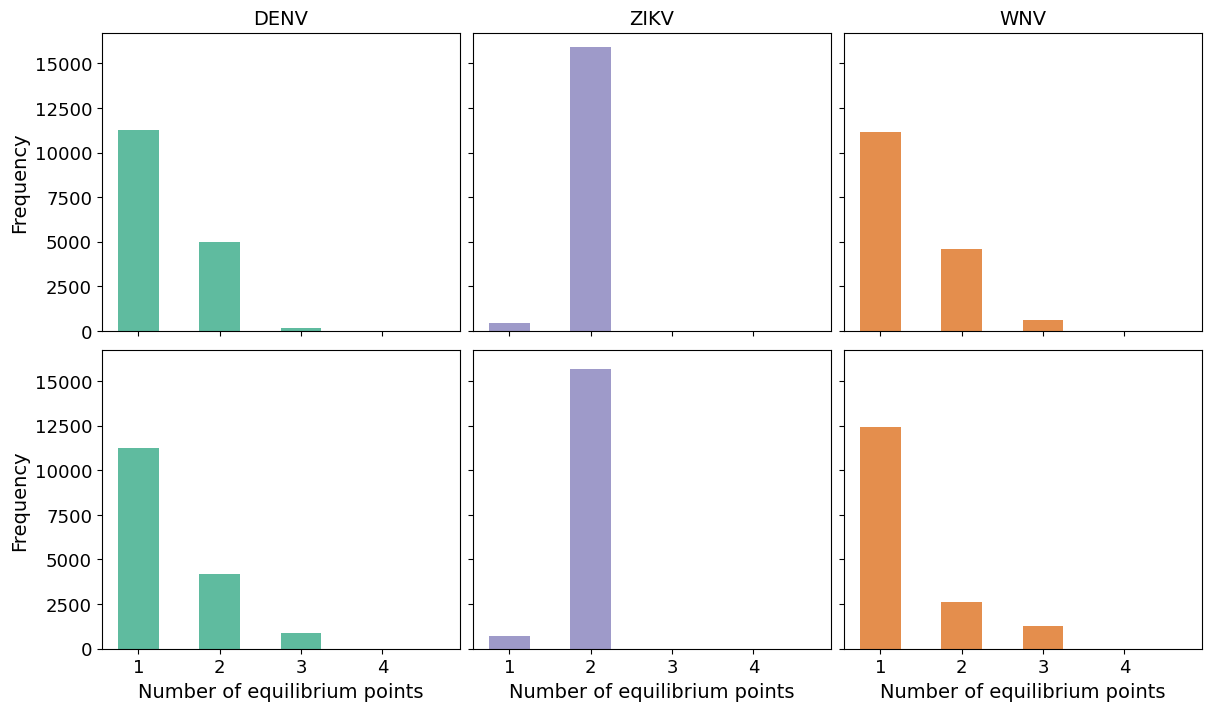

In [207]:
# -------------------------the histogram of the data

# Create the plot
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(figsize=(12, 7), ncols=3, nrows=2, sharey=True, sharex='col', constrained_layout=True)

hist_width = 0.5
bins = np.arange(0.75, 4.3 + hist_width, hist_width)
#bins = 'auto'


ax1.hist(YdenvFerguson, bins=bins, color='#1b9e77', alpha=0.7)
#ax1.set_yscale('log')
ax1.set_ylabel('Frequency', fontsize=14)
#ax1.set_xlabel('Number of equilibrium points', fontsize=14)
ax1.tick_params(labelsize=13)
ax1.set_title('DENV', fontsize=14)

ax2.hist(YzikvFerguson, bins=bins, color='#7570b3', alpha=0.7)
ax2.tick_params(labelsize=13)
#ax2.set_xlabel('Number of equilibrium points', fontsize=14)
ax2.set_title('ZIKV', fontsize=14)

ax3.hist(YwnvFerguson, bins=bins, color='#d95f02', alpha=0.7)
ax3.tick_params(labelsize=13)
#ax3.set_xlabel('Number of equilibrium points', fontsize=14)
ax3.set_title('WNV', fontsize=14)



ax4.hist(YdenvHill, bins=bins, color='#1b9e77', alpha=0.7)
#ax4.set_yscale('log')
ax4.set_ylabel('Frequency', fontsize=14)
ax4.set_xlabel('Number of equilibrium points', fontsize=14)
ax4.tick_params(labelsize=13)


ax5.hist(YzikvHill, bins=bins, color='#7570b3', alpha=0.7)
ax5.tick_params(labelsize=13)
ax5.set_xlabel('Number of equilibrium points', fontsize=14)


ax6.hist(YwnvHill, bins=bins, color='#d95f02', alpha=0.7)
ax6.tick_params(labelsize=13)
ax6.set_xlabel('Number of equilibrium points', fontsize=14)


#plt.savefig("rootsFinal.pdf", bbox_inches = 'tight')

plt.show()